#**Content**

- Confidence Intervals
- Change Points
- Time Series with Linear Regression

# **Confidence Intervals**

- In addition to making predictions, time series models can also provide Confidence Intervals.

- Owing to the **potential error** of our forecast, and **unpredictability of future**, we cannot claim to be a hundred percent sure of our forecasts.

- But we can still, based on our study of time series, say that the future value, would lie in the **range** of [A, B].

- Naturally A becomes the minimum possible value of our target variable at time t, and B becomes the maximum possible value at time t.

- This [A, B] becomes a range for determining the **real possible value** for a certain prediction. 

- It is called as the **confidence interval.**

- It can also be used for performance evaluation.

<center><img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/846/original/Screenshot_2022-08-16_at_11.26.33_AM.png?1660628897" height = '400' width = '800'></center>

- Confidence Intervals are required for determining the uncertainity of your predictions, after making forecasts. 

- Confidence Intervals provide an expected range for the real observation. When making decisions, one can utilise the range information better, than just a single point.



## **How to get Confidence Intervals?**
* Different algorithms have different formulations for CI.
* These can be complicated to derive and are out of scope for this lecture.
* We can get the upper and lower values according to the models available in the `statsmodel` library.
* It takes a value of a parameter: **alpha**, which is a measure of how much confidence we want in our forecasts.

- One example for 1-step ahead forecast CI is to just take the residual distribution. 

- For example, the 95% confidence interval will be

<center> $\large \hat y_{t+1} = \hat y_{t} + u_{resid} ± 2\sigma _{resid}$ </center>

- Note that for a good forecast $U_{resid}$ should be close to 0


<center><img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/847/original/Screenshot_2022-08-16_at_11.29.38_AM.png?1660629069" height = '400' width = '800'><center>

##**How to interpret confidence intervals?**

- Suppose our forecasted value is $\hat{y}$. And you pass a value of **`alpha = 0.05`** for which you get the confidence interval as `(m,n)`.

- It means that the time series model will estimate the upper(n) and lower(m) bound of values around the forecast, where there is only a 5% chance that the real value will **not be** in that range.

- That is, 95% that our forecast will fall within the range `(m,n)`.

Let's use the returned upper and lower bound values of each forecast using the function `conf_int` to create separate series for lower and upper bounds for visualization purpose.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,8)

In [ ]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 17.8MB/s]


In [ ]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
# set index
mobile_sales.set_index('DATE', inplace=True)
# linear interpolation 
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')
# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
    
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAE : 539.029
RMSE : 630.333
MAPE: 0.038


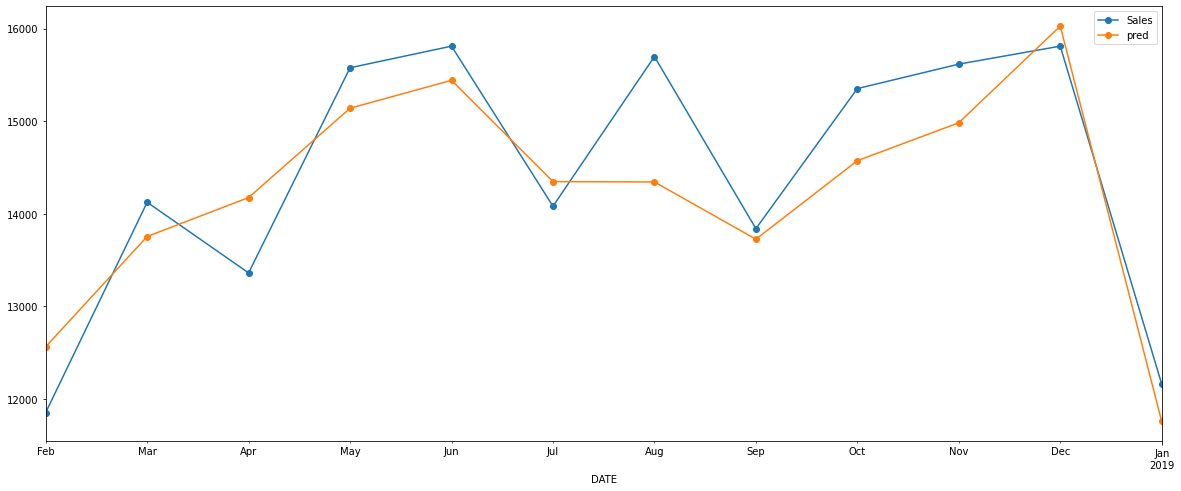

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12)) 
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Using `conf_int`

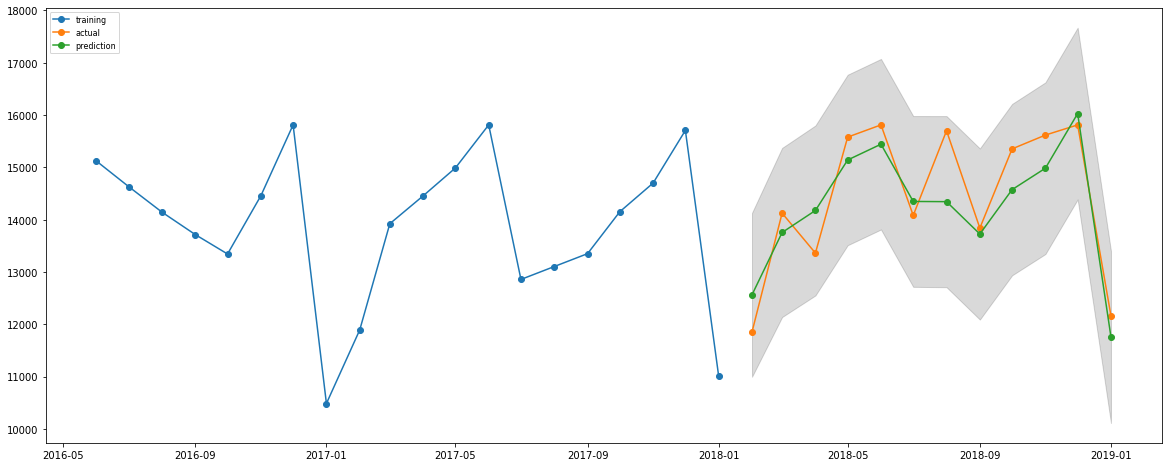

In [ ]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values
plt.plot(train_x['Sales'][-20:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'], 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In the above plot, things to observe are:

- The actual observed values of test set
- Forecasted values of the test set
- Confidence intervals

As shown in the legend of plot, the green and orange lines show the forecasted and actual values respectively.

**Observation**: 
- The greyish area around the predictions are actually the values for 95% confidence intervals.
- The actual values are indeed within the predicted confidence intervals

- In the code we are first getting the forecast for the 1st step just after the last date of fitted training data.
- Then we are using `conf_int` on the forecast, to get the lower and upper bound values for each forecast.

In [ ]:
a = model.get_forecast(steps=1).conf_int(0.05).values
a

array([[10996.00760487, 14128.91565744]])

# **Change Points**

- Consider that we have a time series that looks like the following.

<center> <img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/848/original/Screenshot_2022-08-16_at_11.31.52_AM.png?1660629202" height = '400' width = '800'> </center>

<br>

- By observing the above plot, one can argue that the series has two possible trend lines, as there are two sub-sections that seem to be heading in different directions.

- But recall that in such a case, the **vector sum** of these two trend lines, becomes the new trend line for the entire series. 

<center>$\large \vec{R} = \vec{T_1} + \vec{T_2} $</center>

- The point of intersection of these two trendlines, is called the **changepoint**.

- Changepoint is not very useful in forecasting, as we don't know about any change point in the future.

- We only know about change points in the past. So, it is better to  use them for analysis.

- Also, this concept is useful when we have to explain any decision based on the past value of time series.

#### **Detecting Change Points:**

- There are many methods to detect change points, with various human inputs. For getting some intuition, lets discuss a very simple algorithm that uses a **Sliding Window**

  * Walk through the series with a window of fixed size
  * For each step, compute a **cost** of all elements in the window. There are many options for this cost funtion.
  * Wherever the cost locally peaks, the center of the window can be considered as a changepoint. 
  * We can add other conditions of threshold cost, etc to avaoid making too many detections.

<center><img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/850/original/Screenshot_2022-08-16_at_11.33.50_AM.png?1660629335" height = '400' width = '800'></center>

- Some other methods to detect change points 
<center><img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/406/original/CHANGE_POINT.png?1659598744"></center>

In [ ]:
def plot_changepoints(signal, changepoints):
  for cp in changepoints:
    plt.axvline(x=cp, color='#FA8072')
  plt.plot(signal, '-*', label='signal')

  start = 0
  trends = np.array([])
  for i in changepoints:
    x = np.arange(start, i)
    y = signal[start:i]
    l1 = np.polyfit(x, y, deg=1)
    trend = x*l1[0] + l1[1]
    trends = np.append(trends, trend)
    start = i

  plt.plot(trends, label='trend')
  plt.legend()
  plt.show()

- Here, we are using the **difference in slope for each window**, and wherever the difference is huge, we will mark that as a changepoint.

  - For finding the slope of regression line that goes through all points in a window we can use ```numpy.polyfit``` with 1 degree polynomial. 
  - You can also use ```sklearn.LinearRegression```, but here polyfit syntax is linear. 
  -Both will give similar results

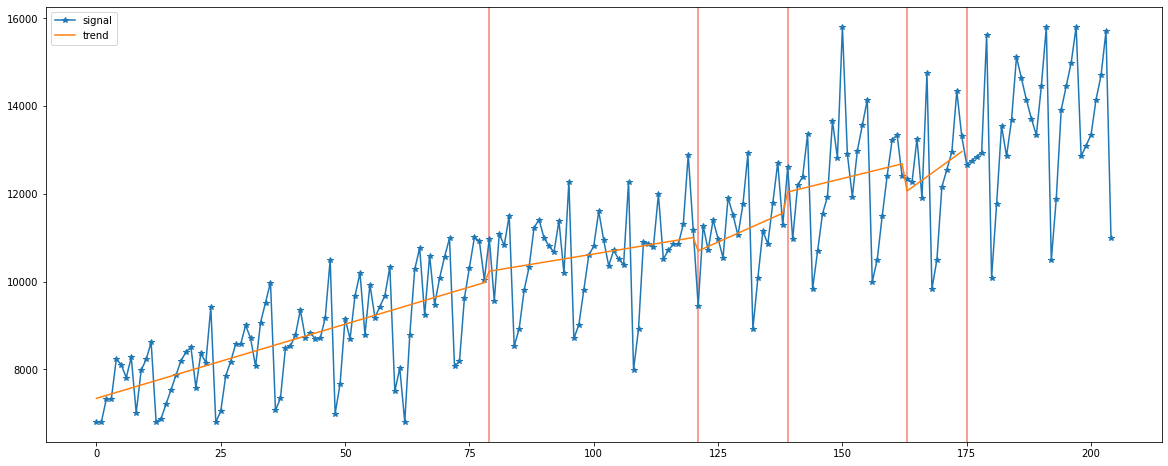

In [ ]:
signal = train_x.Sales # Stationarise for mean as cost function
window=60
def get_slope(y):
  return np.polyfit(np.arange(len(y)), y, deg=1)[0]

changepoints = signal.loc[abs(signal.rolling(window, center=True).apply(get_slope).diff()) > 7.5].index
# converting to index from dates
temp = signal.reset_index()
changepoints = temp.loc[temp['DATE'].isin(changepoints)].index.tolist()

plot_changepoints(signal.values, changepoints)

- Great, Looks these are some valid changepoints. 
- However, maybe depending on the domain one may feel that the changepoints are too frequent, or close to each other. 
- Also one needs to experiment with the window and threshold etc. 

- Let us use a library which has much more complex algorithms to better detect changepoints

Quickly trying the first algorithm from a package called 'rupteres'. If you want to try other on your own, you may visit https://github.com/deepcharles/ruptures

In [ ]:
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 998 kB 4.2 MB/s 


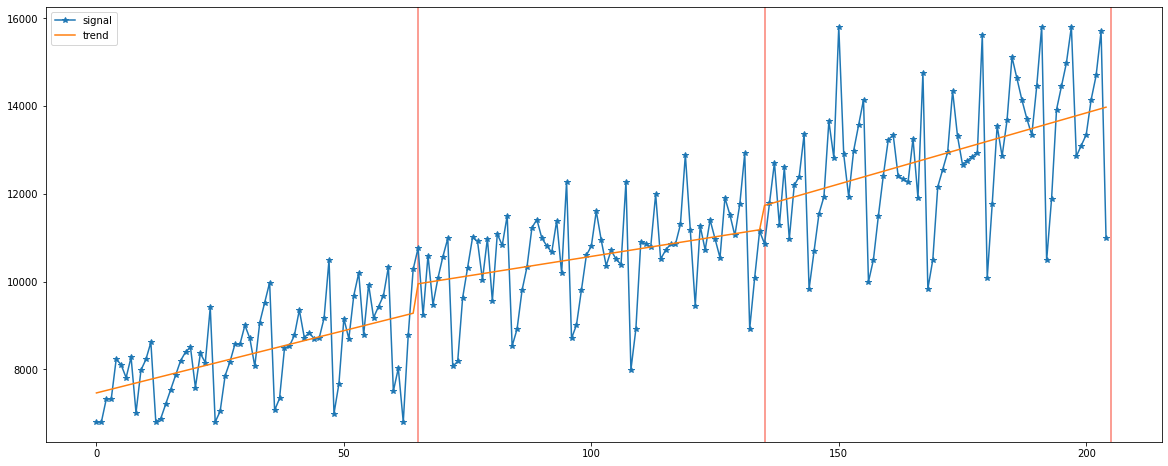

In [ ]:
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal = train_x.Sales.values
# signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
changepoints = algo.predict(pen=5)


plot_changepoints(signal, changepoints)

---


- Now, imagine that you are a Data Scientist at a food chain ‘Xotica.

- Your manager has asked you to forecast the number of visitors for upcoming 39 days (almost 6 weeks) using the number of visitors recorded within the past 1-1.5 years.


### **Reading the data**

In [ ]:
!gdown 1PYs1HQg9gQAtELrptBPD9x6SWP3vvrre

Downloading...
From: https://drive.google.com/uc?id=1PYs1HQg9gQAtELrptBPD9x6SWP3vvrre
To: /content/rest_vis.csv
100% 13.1k/13.1k [00:00<00:00, 16.8MB/s]


In [ ]:
df = pd.read_csv('/content/rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [ ]:
df.shape

(517, 4)

- The provided dataset has features `‘Date’, ‘holiday’, 'weekday' and 'total`(total no. of visitors).

- The data consists of number of **daily** visitors to the restaurant located in the United States, subject to American holidays. 

- The data set contains 517 days: 478 days of restaurant's data and 39 days of data which have `Nan` in `total`.

**Finding NaNs**

In [ ]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

**Keeping a copy of the original data so that in future, it can be used wherever required**

In [ ]:
df1 = df.copy()

**Dropping NaNs**

In [ ]:
df.dropna(inplace = True)

**Seting the `date` column as index after converting it to datetime format**

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


**NOTE:-**
- Here you can see, that the target variable of the time series is the ```total``` column. 
- In our last business case, we saw only date and the target variable.
- However, there are other columns: ```holiday, weekday```.

<br>





**Plotting source data**

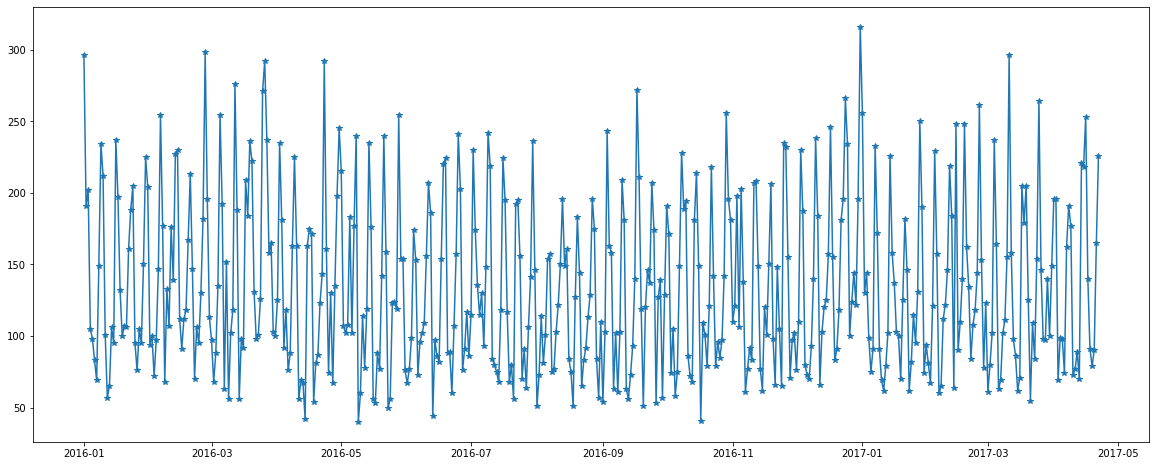

In [ ]:
# Lets take a look at our time series plot
plt.plot(df.index, df['total'], '-*')
plt.show()

- In the above plot, one can see the peaks but can't map those peaks to any particular days. Therefore let's try to decrease the number of days to plot, to get more insights.

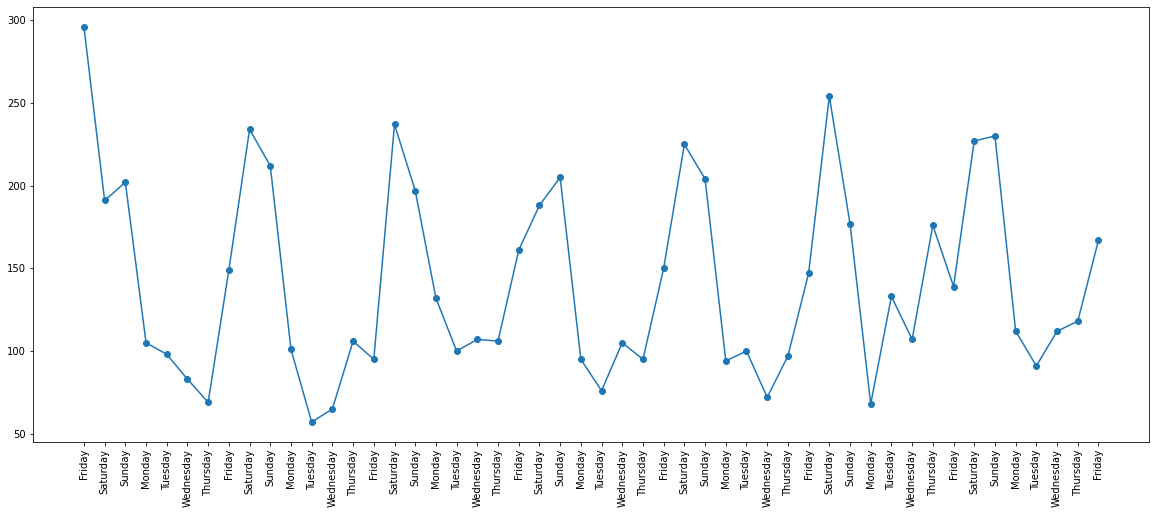

In [ ]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

- It is easily observable that the peaks in the number of visitors is around Saturday and Sunday.

**Plotting the data with holidays**

In [ ]:
df['holiday'].value_counts()

0    446
1     32
Name: holiday, dtype: int64

feature `holiday` is representing whether there is holiday (1) on the day or not(0).

Plot of data with `holiday`. Using a red line to indicate that the given day is a holiday.

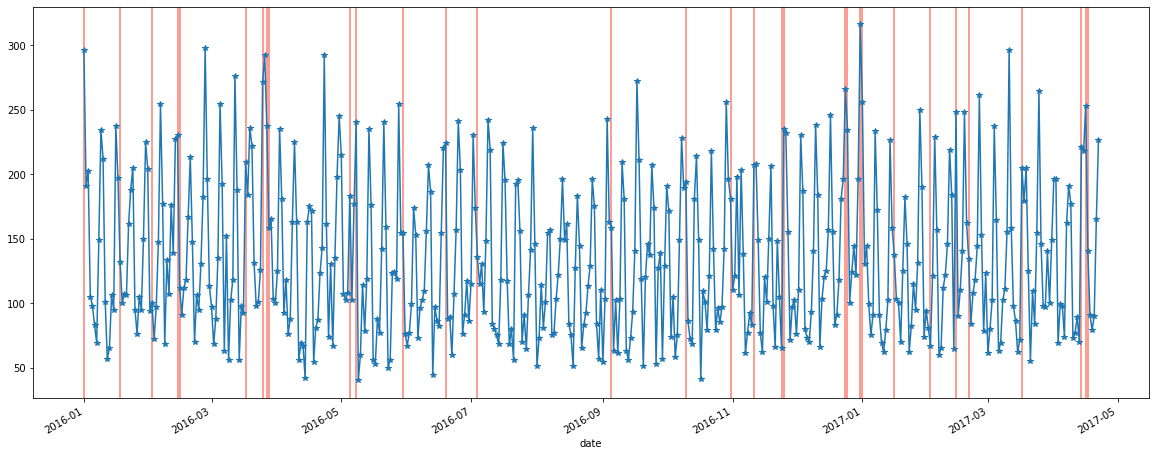

In [ ]:
# Lets take a look at our time series plot
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='#FA8072')
df.total.plot(style='-*')
plt.show()

- One can see that holidays generally see a **peak** in foot falls.

**Now let's try to decompose the time series to see if it follows any pattern**

<Figure size 1440x576 with 0 Axes>

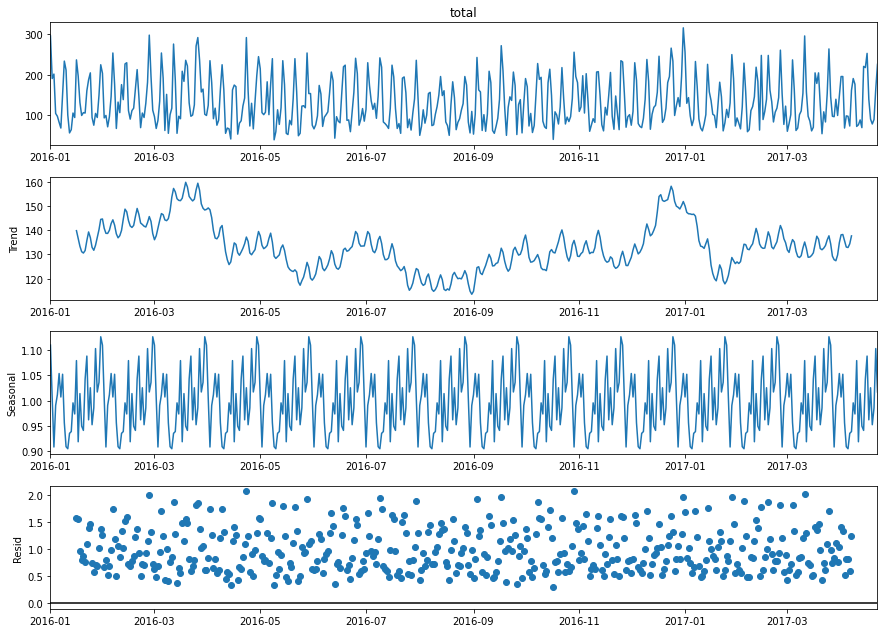

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['total'], model='multiplicative',freq = 30)
fig = plt.figure()  
fig = result.plot() 
fig.set_size_inches(12, 9)
fig.show()

* From the above decomposition, it's visible that the data consists of seasonality and the trend is increasing and decreasing which is understandable as the number of visitors will increase during the weekends.

* As their is seasonality, let's try to use SARIMA for the predictions.

**Lets generate a baseline forecast**

- Now we will fit a **SARIMA model** of seasonal order (1,0,1,7) on the training data.

> **NOTE:-**
- This order is found using `pmdarima` library which we won't be showing here, we are just using the order.
- To find the seasonal order through ACF and PACF plots is quite difficult and it's not very conclusive. 
- Therefore it's better to search from a space of multiple hyperparameter values.

Here,
- $P=1$: Seasonal Auto regressive order.
- $D=0$: Differencing order of the seasonal process.
- $Q=1$: Seasonal moving average order.
- $s=7$: periodicity where the pattern repeat itself (length of cycle).
 - We can observe a **weekly** pattern, hence 7
- $p,d,q$: AR order, MA order and the Differencing order respectively, have been kept default (1,0,0)

<br>


> **Though not compulsary, a Few guidelines that one should keep in mind:**
- $m$: seasonality 
 - We can identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient other than that at lag=0.
- $P, Q$: Seasonal AR and MA orders
 - We generally do not want P+Q to exceed 2.
 - Using increasingly complex models will increase the risk of **overfitting**.
- $D$: Seasonal Differencing order
 - This can be found using `Adfuller test` on the seasonal decompose. 
 - The rule of thumb for our D parameter is that both `D` and the series differencing order `d` should not be greater than 2.



In [ ]:
train = df.iloc[:436]
test = df.iloc[436:]

In [ ]:
test.tail()

,weekday,holiday,total
date,,,
2017-04-18,Tuesday,0,91.0
2017-04-19,Wednesday,0,79.0
2017-04-20,Thursday,0,90.0
2017-04-21,Friday,0,165.0
2017-04-22,Saturday,0,226.0


**Training a pure seasonality based model, by ignoring the `p, d, q` hyperparamters**

In [ ]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


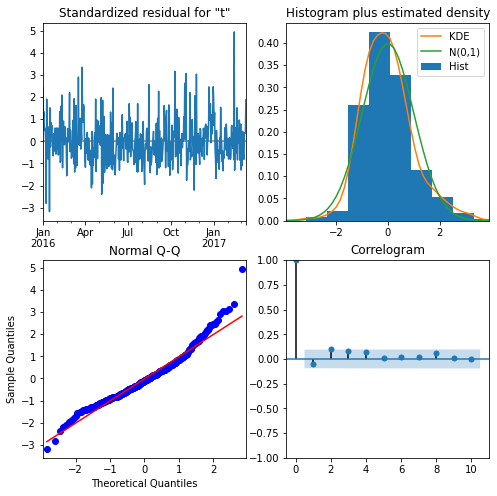

In [ ]:
results.plot_diagnostics(figsize=(8,8));

> **Inference about the patterns in the residuals from above results:**

- The residuals have **constant variance**.
- Majority of the dots lie on the red line in the Normal Q-Q plot 
 - Hence, the residuals follow a **normal distribution.**
- The residuals are **not auto correlated** as there is no significant pattern.


  

**Some properties of residuals in time series forecasting:**
 * The residuals should **not be correlated**
  - Correlated residuals will imply that we are unable to capture some information / pattern in our model.
 * It is useful if the residuals are **normally distributed** 
  - It makes calculating the prediction intervals easier.
 * The residuals should have a **zero mean**
  - Otherwise, the forecast can said to be biased. 
  - Because a positive mean would mean would imply underfitting and vica-versa

# **Time Series with Linear Regression**

- In the ADF test performed earlier we saw that the data is **stationary**

- Therefore, let's try to forecast the values using linear regression.

In [ ]:
df = df1.copy()
df['date'] = pd.to_datetime(df['date'])

- We have seen in the decomposed plots that the number of visitors alter during weekdays and weekends and there is also some pattern in the trends over the weeks.

- Earlier we saw that the number of visitors was higher on the weekends according to the data.

- Therefore let's try engineering a new feature which indicates whether there is a weekend or not.

In [ ]:
df["weekday"] = np.where(((df["weekday"] == "Friday") | (df["weekday"] == "Thursday") | (df["weekday"] == "Wednesday") | (df["weekday"] == "Tuesday") | (df["weekday"] == "Monday")), "working_day", "weekend")
intmdt = pd.get_dummies(df['weekday'])
df = pd.concat([df, intmdt],axis =1 )
df.head()

,date,weekday,holiday,total,weekend,working_day
0,2016-01-01,working_day,1,296.0,0,1
1,2016-01-02,weekend,0,191.0,1,0
2,2016-01-03,weekend,0,202.0,1,0
3,2016-01-04,working_day,0,105.0,0,1
4,2016-01-05,working_day,0,98.0,0,1


**As we have seen the repetition of patterns over the months, therefore let's engineer a feature which consist of the average of the last one month's values**

<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/852/original/Screenshot_2022-08-16_at_11.37.55_AM.png?1660629603" width="800" height="500">

**Now, calculating the values of past 1-31 days number of visitors for each observation storing in columns with name Lag_i where i is the previous ith day's observation**

In [ ]:
for i in range(1,32):
  df["Lag_{}".format(i)] = df['total'].shift(i)

- We could also have used `resample('M')` in combination with `groupby()` in order to get the average of last 31 days.
- But here we are using `Lag` because we also want to have different `Lag` values.
- Computationally it would make sense to use `resample`, but here we are just going to try different combinations of features.

**Using the average of past one months values for each observation as a feature named `average_monthly_lag`**

In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,32)]
df.dropna(inplace = True)    # Drop because some Lags will be NaN.
df['last_month_avg_level'] = df.loc[:,lis].sum(axis=1)/31
df.head()

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_23,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742
34,2016-02-04,working_day,0,97.0,0,1,72.0,100.0,94.0,204.0,...,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,129.774194
35,2016-02-05,working_day,0,147.0,0,1,97.0,72.0,100.0,94.0,...,65.0,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,129.516129


**Similarly, using a feature 'average_weekly_lag' for an average past 7 days observations**



In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,8)]
df['last_week_avg_level'] = df.loc[:,lis].sum(axis=1)/7
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000


**We can have 'average_biweekly_lag' as well**

In [ ]:
lis = ["Lag_{}".format(i) for i in range(1,15)]
df['last_2week_avg_level'] = df.loc[:,lis].sum(axis = 1)/14
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level,last_2week_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286,139.214286
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429,136.500000
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000,136.500000


**Now lets capture weekly seasonality**

In [ ]:
df['dayofweek'] = df['date'].dt.dayofweek
df['sale_wrt_dow'] = df.groupby('dayofweek')['total'].transform('mean')
df[['sale_wrt_dow', 'dayofweek']].drop_duplicates()

,sale_wrt_dow,dayofweek
31,89.593750,0
32,94.531250,1
33,94.687500,2
34,99.015625,3
35,147.171875,4
36,229.125000,5
37,178.460317,6


In [ ]:
df.shape

(447, 42)

**Retrieving the present features and columns in the dataframe to decide which featues we can use in predictions**

In [ ]:
df.columns

Index(['date', 'weekday', 'holiday', 'total', 'weekend', 'working_day',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22',
       'Lag_23', 'Lag_24', 'Lag_25', 'Lag_26', 'Lag_27', 'Lag_28', 'Lag_29',
       'Lag_30', 'Lag_31', 'last_month_avg_level', 'last_week_avg_level',
       'last_2week_avg_level', 'dayofweek', 'sale_wrt_dow'],
      dtype='object')

In [ ]:
import copy             #dfo has the data with all the columns
dfo = df.copy()

**Using a combination of newly engineered variables with Lag_1 and weekend training the linear regression model**

**Dropping all the columns which we don't need to use while predicting the number of visitors in the test data**

In [ ]:
df = dfo.copy()
df = df[['total', 'Lag_1', 'last_month_avg_level', 'last_week_avg_level', 
          'last_2week_avg_level', 'sale_wrt_dow', 'holiday']] 
df.head()

,total,Lag_1,last_month_avg_level,last_week_avg_level,last_2week_avg_level,sale_wrt_dow,holiday
31,94.0,204.0,143.419355,135.714286,139.214286,89.593750,0
32,100.0,94.0,136.903226,135.571429,136.500000,94.531250,1
33,72.0,100.0,133.967742,139.000000,136.500000,94.687500,0
34,97.0,72.0,129.774194,134.285714,134.000000,99.015625,0
35,147.0,97.0,129.516129,134.571429,133.357143,147.171875,0


**Train-Test Split**

In [ ]:
train = df.iloc[:df.shape[0]-42].dropna()
test = df.iloc[df.shape[0]-42:]


train_X = train.drop(["total"],axis =1)
train_y = train['total']
test_X = test.drop(["total"],axis =1)
test_y = test['total']

**Training Linear Regression Model**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Train and pred
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = pd.Series(model.predict(test_X), index=test.index)
mape(test['total'],y_pred)

0.1550950649148067

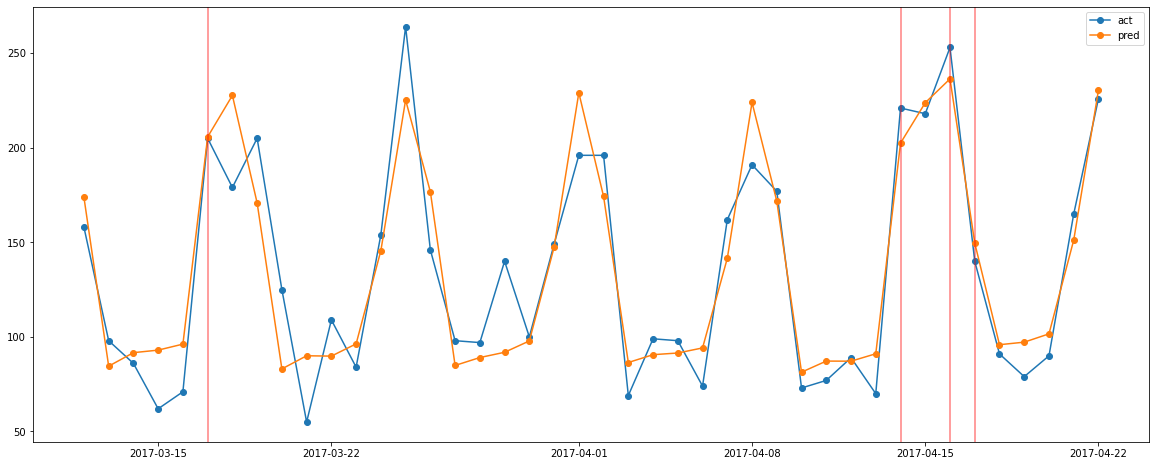

In [ ]:
plt.plot(dfo.tail(42)['date'], test_y, '-o', label='act')
plt.plot(dfo.tail(42)['date'], y_pred, '-o', label='pred')
for x in dfo[-42:].query('holiday==1')['date']: 
    plt.axvline(x=x, color='red', alpha = 0.5)
plt.legend()

- This performance is surprisingly very good. 
- Note that this is a much simpler algorithm than SARIMAX. 

Further improvements can be done with

- Thinking of more inovative features.
- Better feature selection
- Different regressors and Hyper parameter tuning
- Stacking / Cascading etc.

> **IMPORTANT NOTE**
> - please note that SARIMAX forecast was 1 - 42 days into the future. This forecast is only 1 day into the future!! Lag_1 has been used as a feature!
> - For multiple days ahead forecast you need a **new LR for each horizon**. Shift your target by -k, where k is horizon-1